# CVPR 2018 WAD Video Segmentation Challenge

From April to June 2018, there was a competition on kaggle hosted by the 2018 CVPR workshop on autonomous driving (WAD) in which competitors were asked to segment movable objects, such as cars and pedestrians, at instance level within image frames captured by vehicles.
Competition details can be found here: https://www.kaggle.com/c/cvpr-2018-autonomous-driving

This solution uses Mask-R-CNN and reached place 51.


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import imgaug
from imgaug import augmenters as iaa

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = '/home/paperspace/MASK_RCNN/mask_rcnn_coco.h5'

# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [6]:
class WADConfig(Config):
    """Configuration for training on the WAD dataset.
    Derives from the base Config class and overrides values specific
    to the WAD dataset.
    """
    # Name for the configuration
    NAME = "WAD"

    # Train on 1 GPU and only 1 image per GPU because images are big. 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    # background + 8 classes + 8 group classes when bounderies cannot be distinguished by labelers + 1 rest
    NUM_CLASSES = 1 + 17  
    
    
config = WADConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                30
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8

## Notebook Preferences

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Read the data.

Extend the Dataset class and add a method to load the dataset, `load_wad()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

The data is split in training and validation data. This is specified in `load_wad(...)` by the parameter `subset`. Use `subset = 'train'` for training data, `subset = 'val'` for validation data and `subset = 'test'` for test data. `Num_val` gives the number of validation examples.

While splitting the data into train and validation set, one needs to be careful, as there are always two images taken by the same vehicle at the same time but with different cameras. That is why these images are quite similar. So to get correct validation results either both or none of these respective images need to be part of the validation set. This is taken care of in `load_wad(...)`. Otherwise it could happen that the model is trained on the first image (among others) and validated on the second image (among others). In that case overfitting could not be detected anymore.

See here for more information on the data: https://www.kaggle.com/c/cvpr-2018-autonomous-driving/data

In [8]:
class WADDataset(utils.Dataset):

    def load_wad(self, dataset_dir, subset = 'train', num_val = 100, seed = 42):
        
        # Add classes
        self.add_class("wad", 33, "car")
        self.add_class("wad", 34, "motorbicycle")
        self.add_class("wad", 35, "bicycle")
        self.add_class("wad", 36, "person")
        self.add_class("wad", 37, "rider")
        self.add_class("wad", 38, "truck")
        self.add_class("wad", 39, "bus")
        self.add_class("wad", 40, "tricycle")
        self.add_class("wad", 161, "car_group")
        self.add_class("wad", 162, "motorbicycle_group")
        self.add_class("wad", 163, "bicycle_group")
        self.add_class("wad", 164, "person_group")
        self.add_class("wad", 165, "rider_group")
        self.add_class("wad", 166, "truck_group")
        self.add_class("wad", 167, "bus_group")
        self.add_class("wad", 168, "tricycle_group")
        self.add_class("wad", 65, "rest")

        # add images
        if subset == 'test':
            image_ids = os.listdir(dataset_dir)
            for image_id in image_ids:
                self.add_image("wad", image_id, path = dataset_dir + image_id )
            return
        
        image_ids = os.listdir(dataset_dir)
        
        lst1 = [idx.split('_')[1] for idx in image_ids]
        new_lst1 = list(set(lst1))
        random.Random(seed).shuffle(new_lst1)
        val_lst = new_lst1[:num_val]            
        
        for image_id in image_ids:
            if subset == 'train':
                if image_id.split('_')[1] not in val_lst:
                    self.add_image("wad", image_id, path = dataset_dir + image_id )
            elif subset == 'val':
                if image_id.split('_')[1] in val_lst:
                    self.add_image("wad", image_id, path = dataset_dir + image_id )
            else:
                print('variable subset must bei either "train", "val" or "test" ')
                return
                    

    def load_image(self, image_id):
        image = skimage.io.imread(self.image_info[image_id]['path'])
        return image
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "wad":
            return info["id"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        # get mask_dir from image path
        mask_dir = '/home/paperspace/kaggle/wad/data/train_label/' + self.image_info[image_id]['id'][0:25] + '_instanceIds.png'
        # class mapping 
        class_map = {33:1, 34:2, 35:3, 36:4, 37:5, 38:6, 39:7, 40:8, 161:9, 162:10, 163:11, 164:12, 165:13, 166:14, 167:15, 168:16, 65:17}
        labels = imread(mask_dir)
        
        cls_inst = np.unique(labels)
        
        masks = np.zeros((labels.shape[0], labels.shape[1], len(cls_inst) - 1))
        class_ids = np.zeros(len(cls_inst)-1, dtype = 'uint8')
        for i, value in enumerate(cls_inst):
            # ignore background class: 
            # background pixels have value 255, which is always the first value in cls_inst as 
            # the values for actual classes start at 33000
            # so use index i-1 for masks and class_ids
            if value != 255:
                masks[:, :, i-1] = (labels == value)
                class_ids[i-1] = class_map[int(value / 1000)]
            
        return masks, class_ids

In [10]:
dataset_dir = '/home/paperspace/kaggle/wad/data/train_color/'
# Training dataset
dataset_train = WADDataset()
dataset_train.load_wad(dataset_dir, subset = 'train', num_val = 100)
dataset_train.prepare()

# Validation dataset
dataset_val = WADDataset()
dataset_val.load_wad(dataset_dir, subset = 'val', num_val = 100)
dataset_val.prepare()

In [11]:
print('number of training images: ' + str(len(dataset_train.image_ids)))
print('number of validation images: ' + str(len(dataset_val.image_ids)))

number of training images: 39025
number of validation images: 197


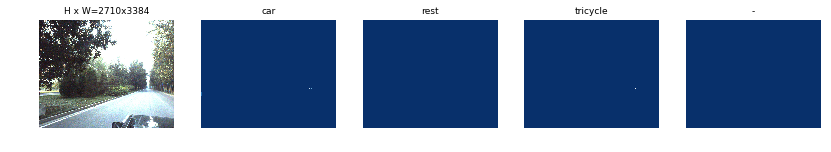

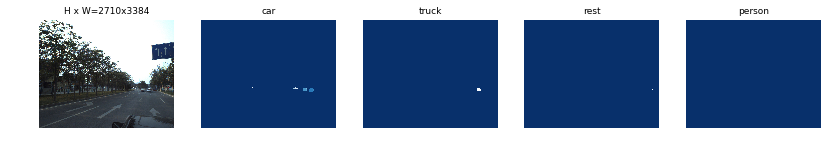

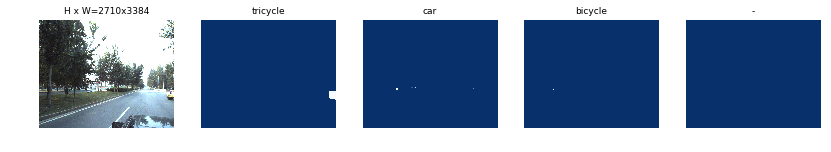

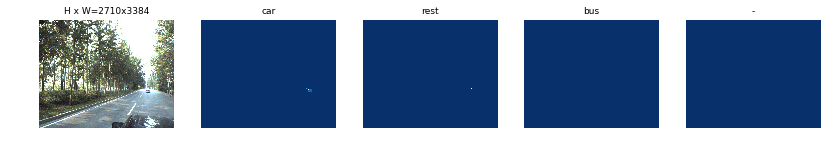

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
COCO_MODEL_PATH = "/home/paperspace/Mask_RCNN/mask_rcnn_coco.h5"
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [8]:
# Or specify weigths directly
model.load_weights("/home/paperspace/github/Mask_RCNN/logs/wad20180429T1426/mask_rcnn_wad_0055.h5")

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Simply pass `layers="all"` to train all layers.

I tried using data augmentation but this didn't improve my score, which is actually not surprising as the model wasn't even overfitting. Due to so many high resolution images training took a very long time and I didn't have the time and computing power to train it long enough.

So I didnt't use data augmentation here, but the following code shows how it would have worked.

In [12]:
# Define the augmentation operations
# first version: cropping, horizontal flipping and zooming
augmentation = iaa.Sequential([
   iaa.Crop(px = (900, 0, 0, 0)),
        iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Multiply((0.8, 1.5))
    ])])

# second version: only cropping
augcrop = iaa.Crop(px = (1000, 0, 0, 0))

In [29]:
image = dataset_train.load_image(105)
image_aug = augmentation.augment_image(image)
image_crop = augcrop.augment_image(image)

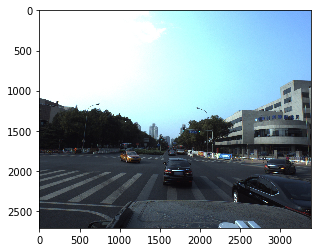

In [25]:
# original image
plt.imshow(image)

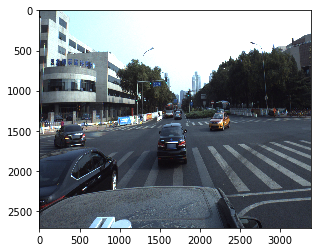

In [30]:
# augmentated image first version
plt.imshow(image_aug)

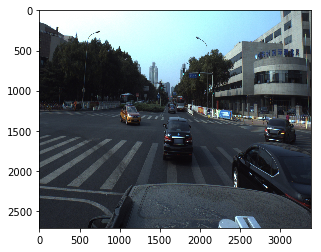

In [28]:
#augmentated image second version
plt.imshow(image_crop)

In [31]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')

In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10,
            epochs=58, 
            layers="all")


Starting at epoch 56. LR=0.0001

Checkpoint Path: /home/paperspace/github/Mask_RCNN/logs/wad620180429T1426/mask_rcnn_wad6_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


## Detection

In [32]:
class InferenceConfig(WADConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# set path to weights
model_path = "/home/paperspace/github/Mask_RCNN/logs/wad20180429T1426/mask_rcnn_wad_0055.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/paperspace/github/Mask_RCNN/logs/wad20180429T1426/mask_rcnn_wad_0055.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (30,)                 min:    0.00000  max: 3384.00000  float64
gt_class_id              shape: (53,)                 min:    1.00000  max:   17.00000  uint8
gt_bbox                  shape: (53, 4)               min:    0.00000  max:  454.00000  int32
gt_mask                  shape: (512, 512, 53)        min:    0.00000  max:    1.00000  float64


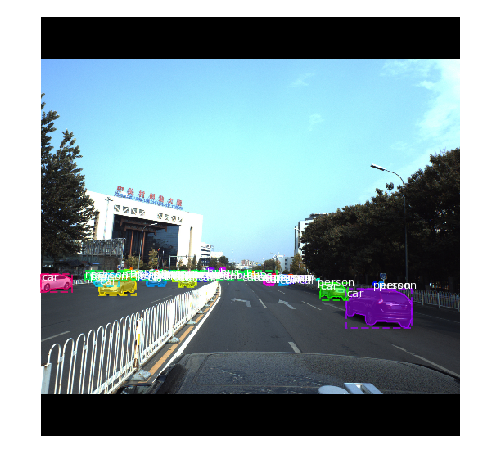

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 30)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32


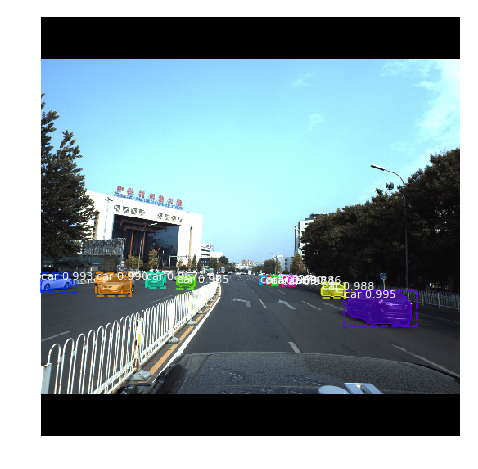

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [21]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.21562737676


## Create Submission

Load test data

In [36]:
dataset_test_dir = '/home/paperspace/kaggle/wad/data/test/test/'
dataset_test = WADDataset()
dataset_test.load_wad(dataset_test_dir, subset = 'test')
dataset_test.prepare()

In [37]:
print ('Number of test images: ', len(dataset_test.image_ids))

Number of test images:  1917


Inverse class mapping

In [17]:
class_map = {33:1, 34:2, 35:3, 36:4, 37:5, 38:6, 39:7, 40:8, 161:9, 162:10, 163:11, 164:12, 165:13, 166:14, 167:15, 168:16, 65:17}
class_map_inv = {v: k for k, v in class_map.items()}

RLE-Encoding

In [18]:
def rle_encoding2(x):
    """ Run-length encoding based on
    https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
    """
    assert x.dtype == np.bool
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.append([b, 0])
        run_lengths[-1][1] += 1
        prev = b
    return '|'.join('{} {}'.format(*pair) for pair in run_lengths)

Create submission file

In [19]:
import pandas as pd

sub = pd.DataFrame()
row = 0
for idx in range(0, 1917):    # 1917 test images
    print(idx)
    image_id = dataset_test.image_info[idx]['id']
    image = dataset_test.load_image(idx)
    results = model.detect([image])
    r = results[0]
    
    masks = r['masks']    
    scores = r['scores']
    class_ids = r['class_ids']
                          
    if np.sum(masks) > 0:
        for i in range(masks.shape[2]):
            rle = rle_encoding2(masks[:, :, i])
            if len(rle)>0:
                sub.loc[row, 0] = image_id
                sub.loc[row, 1] = class_map_inv[class_ids[i]]
                sub.loc[row, 2] = np.sum(masks[:, :, i])
                sub.loc[row, 3] = scores[i]
                sub.loc[row, 4] = rle
                row += 1
    else:
        sub.loc[row, 0] = image_id
        row += 1

sub.columns = (['ImageID', 'LabelID', 'PixelCount', 'Confidence', 'EncodedPixels'])
sub = sub[sub.LabelID.isnull()==False]
sub.LabelID = sub.LabelID.astype(int)
sub.PixelCount = sub.PixelCount.astype(int)

from IPython.display import FileLink, FileLinks
sub.to_csv('submission_180609.csv', index=False)
FileLink('submission_180609.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916


/home/paperspace/github/Mask_RCNN/samples/wad/submission_180610.csv

In [95]:
sub

,ImageID,LabelID,PixelCount,Confidence,EncodedPixels
0,461187481507a3cbc5dbecc6558fad5e.jpg,33,14028,0.995278,6045367 58|6048748 67|6052128 77|6055507 86|60...
1,461187481507a3cbc5dbecc6558fad5e.jpg,33,13902,0.992416,5966946 31|5970322 46|5973700 58|5977078 68|59...
2,461187481507a3cbc5dbecc6558fad5e.jpg,33,5665,0.983680,6099721 7|6103104 8|6106486 11|6109866 15|6113...
3,461187481507a3cbc5dbecc6558fad5e.jpg,33,12262,0.982182,6093239 6|6096616 18|6099997 24|6103378 30|610...
4,461187481507a3cbc5dbecc6558fad5e.jpg,33,11014,0.981623,6168035 50|6171416 55|6174794 64|6178173 71|61...
5,461187481507a3cbc5dbecc6558fad5e.jpg,33,3671,0.944522,5909297 1|5912658 3|5912679 7|5916038 16|59160...
6,461187481507a3cbc5dbecc6558fad5e.jpg,33,1161,0.932226,6038880 16|6042259 25|6045641 29|6049024 31|60...
7,461187481507a3cbc5dbecc6558fad5e.jpg,33,6692,0.926284,6232755 13|6236134 40|6239510 54|6242892 59|62...
8,461187481507a3cbc5dbecc6558fad5e.jpg,33,4318,0.917092,6191588 13|6194968 20|6198348 27|6201728 34|62...
9,461187481507a3cbc5dbecc6558fad5e.jpg,33,223,0.846453,6239021 7|6242403 6|6245780 10|6249161 11|6252...
